# Nettoyage des données

## Set up

### Mise en place de l'environnement

In [97]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import missingno as msno 
import re

import sys
sys.path.insert(0, "/home/apprenant/PycharmProjects/open-food-facts")

In [98]:
# On veut pouvoir voir toutes les colonnes et toutes les lignes des dataframes
pd.set_option("max_rows", None)
pd.set_option("max_columns", None)

### Import des données

In [99]:
df = pd.read_csv("/home/apprenant/Downloads/openfoodfacts.tsv", sep='\t', low_memory=False)

## Suppression des colonnes inutilisées

On va garder uniquement les 27 colonnes qu'on va utiliser comme défini dans la partie analyse.

In [100]:
df = df[['product_name', 'brands', 'countries_en', 'pnns_groups_1',
         'ingredients_text', 'allergens', 'traces', 'additives_en',
         'ingredients_from_palm_oil_n','nutrition_grade_fr', 'energy_100g',
         'saturated-fat_100g', 'sugars_100g', 'fiber_100g', 'salt_100g',
         'fat_100g', 'carbohydrates_100g',
         'proteins_100g', 'nutrition-score-fr_100g', 'fruits-vegetables-nuts_100g',
         'vitamin-d_100g', 'vitamin-c_100g', 'calcium_100g', 'iron_100g', 'image_url',
         'generic_name', 'pnns_groups_2']]
print(df.shape)

(356027, 27)


## Selection des produits disponibles en France

On ne va travailler que sur les produits disponibles en France. On commence par normaliser l'ensemble des cellules contenant le mot "France" pour pouvoir les récupérer ensuite. 

In [101]:
# Permet de convertir toutes les chaines de caractères contenant France en France.
df["countries_en"] = df["countries_en"].apply(
    lambda x: "France" if re.match(r".*(France).*", str(x), re.IGNORECASE) else x
)
df = df[df.countries_en == 'France']
print(df.shape)

(129320, 27)


On constate qu'on a conservé 129320 lignes sur les 356027 initiales. 

## product_name

On va remplacer les valeurs manquantes de product_name par celles contenues dans generic_name quand c'est possible. Ensuite on supprimera les lignes où product_name est vide qui sont donc inutilisables.

In [102]:
temp = (df["product_name"].isnull().sum())

In [103]:
# On remplace les valeurs manquantes de product_name par generic_name 
df.loc[df["generic_name"].notna() & df["product_name"].isna(), "product_name"] = df["generic_name"]

In [104]:
# Calcul du nombre de valeurs modifiées
temp - (df["product_name"].isnull().sum())

32

In [105]:
# On supprime les lignes où product_name n'est pas renseigné
df.dropna(subset=["product_name"], inplace=True)
print(df.shape)

(123065, 27)


## Suppression des doublons

On va supprimer les lignes en doubles pour n'en garder qu'une seule. 

In [106]:
df.drop_duplicates(inplace=True)
print(df.shape)

(122505, 27)


## pnns_groups_1

On va remplacer les valeurs manquantes de pnns_groups_1 par celles contenues dans pnns_groups_2 pour commencer.

In [107]:
temp=(df["pnns_groups_1"].isnull().sum())

In [108]:
df.loc[df["pnns_groups_2"].notna() & df["pnns_groups_1"].isna(), "pnns_groups_1"] = df["pnns_groups_2"]

In [109]:
# Calcul du nombre de valeurs modifiées
temp-df["pnns_groups_1"].isnull().sum()

2623

## Gestion des valeurs nutritionnelles numériques

### Suppression des lignes inexploitables

On va supprimer les lignes dont il manque le nutriscore et les éléments pour le calculer. 

In [110]:
# On supprime les lignes où le nutriscore et les valeurs nutritionnelles ne sont pas renseignées
df.dropna(subset=['nutrition-score-fr_100g','saturated-fat_100g', 'sugars_100g', 'fiber_100g',
          'salt_100g', 'fat_100g',
          'carbohydrates_100g', 'proteins_100g',
          'fruits-vegetables-nuts_100g'], how='all', inplace=True)
print(df.shape)

(97015, 27)


### Remplacement des valeurs nutritionnelles manquantes

On va remplacer les valeurs nutritionnelles manquantes par 0.

In [111]:
# On liste les colonnes dont on veut remplacer les valeurs manquantes par 0
cols = ['ingredients_from_palm_oil_n',
         'saturated-fat_100g', 'sugars_100g', 'fiber_100g', 'salt_100g',
         'fat_100g', 'carbohydrates_100g',
         'proteins_100g', 'fruits-vegetables-nuts_100g',
         'vitamin-d_100g', 'vitamin-c_100g', 'calcium_100g',
        'iron_100g', 'energy_100g']
# On fait une liste remplie de 0 de même longueur que le nombre de colonnes à modifier
vals = np.zeros(len(cols))
# On combine ces 2 listes dans un dictionnaire pour pouvoir l'entrer en paramètre de fillna
dico = dict(zip(cols, vals))
# On remplace les valeurs manquantes par 0
df.fillna(dico, inplace=True)

On va calculer les colonnes manquantes pour l'énergie à partir des autres valeurs nutritionnelles. 

In [112]:
#  E KJ = (37 x lipides) + (17 x protéines) + (17 x glucides) + (8 x fibres)
# On calcule l'énergie suivant la formule ci-dessus quand la valeur est manquante
df["energy_100g"] = df.apply(
    lambda row: 37*row['fat_100g'] + 17*row['proteins_100g'] + 17*row['carbohydrates_100g'] + 8*row['fiber_100g']
    if np.isnan(row["energy_100g"]) 
    else row["energy_100g"], 
    axis=1)


On va calculer les nutriscores manquants. 

In [113]:
# Mise en place des listes contenant les limites pour chaque valeur nutritionnelle
# Limites spécifiques aux solides
ptsNrjS=[335, 670, 1005, 1340, 1675, 2010, 2345, 2680, 3015, 3350]
ptsSucS=[4.5, 9, 13.5, 18, 22.5, 27, 31, 36, 40, 45]
ptsLegS=[40,60,80,80,80]

# Limites partagées entre solides et liquides
ptsSod=[0.090, 0.180, 0.270, 0.360, 0.450, 0.540, 0.630, 0.720, 0.810, 0.900]
ptsGra=[1, 2.1, 3.2, 4.3, 5.4, 6.5, 7.6, 8.7, 9.8, 10.9]
ptsFib=[0.9, 1.9, 2.8, 3.7, 4.7]
ptsPro=[1.6, 3.2, 4.8, 6.4, 8.0]

# Limites spécifiques aux liquides
ptsNrjL=[0, 30 , 60, 90, 120, 150, 180, 210, 240, 270]
ptsSucL=[0, 1.5, 3, 4.5, 6, 7.5, 9, 10.5, 12, 13.5]
ptsLegL=[40, 40, 60, 80, 80, 80, 80, 80, 80, 80]

In [114]:
def calcul_points(val, pts):
    """Donne le nombre de points de la valeur val par rapport à son placement relatif à la liste pts"""
    points=0
    # On parcourt parcourt la liste des limites jusqu'à trouver une limite majorant notre valeur nutritionnelle
    for points in range(len(pts)):
        if val <= pts[points]:
            return points
    return points+1


def nutriscore(catg, nrj, suc, gra, sel, leg, fib, pro):
    """Calcule le nutriscore à partir des valeurs nutritionnelles"""
    # Compteur de points positifs
    p=0
    # Compteur de points négatifs 
    n=0
    p = calcul_points(fib, ptsFib)
    n = n + calcul_points(gra, ptsGra) + calcul_points(sel/2.54, ptsSod)
    # Cas où le produit est un liquide
    if "beverage" in str(catg).lower():
        p = p + calcul_points(leg, ptsLegL)
        n = n + calcul_points(nrj, ptsNrjL) + calcul_points(suc, ptsSucL)
    # Cas où le produit est un solide
    else:
        p = p + calcul_points(leg, ptsLegS)
        n = n + calcul_points(nrj, ptsNrjS) + calcul_points(suc, ptsSucS)
    # Cas où les points des protéines ne sont pas pris en comptes
    if n >= 11 and leg < 100 and "fromage" not in str(catg).lower():
        return(n-p)
    # Cas où les points des protéines sont pris en compte
    p = p + calcul_points(pro, ptsPro)
    return (n-p)

In [115]:
# On calcule les nutriscores qui ne sont pas renseignés
df["nutrition-score-fr_100g"] = df.apply(
    lambda row: nutriscore(row["pnns_groups_1"], row["energy_100g"], 
                           row["sugars_100g"], row["saturated-fat_100g"],
                           row["salt_100g"], row["fruits-vegetables-nuts_100g"], 
                           row["fiber_100g"], row["proteins_100g"]) 
    if np.isnan(row["nutrition-score-fr_100g"]) 
    else row["nutrition-score-fr_100g"], 
    axis=1)


### Suppression des valeurs nutritionnelles aberrantes

On va supprimer les lignes dont les valeurs sont négatives ou au dessus de 100 grammes pour chacune des valeurs nutritionnelles utilisées. Pour commencer, on va fixer les valeurs limites. Pour les valeurs nutritionnelles, elles devront être comprises entre 0 et 100 grammes. Pour le nutriscore, il est toujours compris entre -15 et 40. Regardons la répartition de l'énergie. 

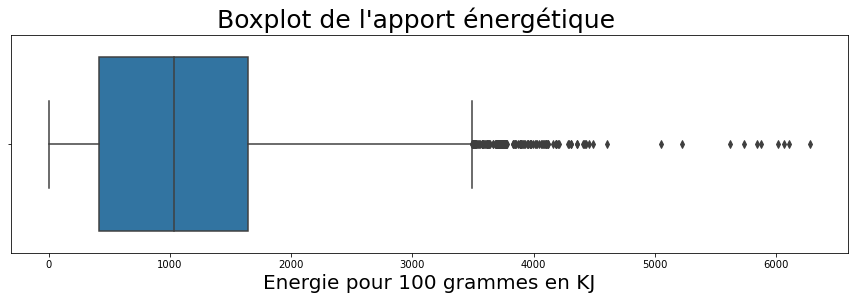

In [116]:
ax = sns.boxplot(x=df['energy_100g'])
fig = plt.gcf()
# Modification de la taille
fig.set_size_inches(15,4)
# Ajout du titre et de la légende
fig.suptitle("Boxplot de l'apport énergétique", fontsize=25)
plt.xlabel("Energie pour 100 grammes en KJ", fontsize=20);

In [117]:
# Echantillon des produits dont l'énergie est supérieure à 3700 kjoules
print(df.loc[df['energy_100g'] > 3700][["product_name", "energy_100g"]].sample(10))

                                             product_name  energy_100g
338218                          Oli Carbonell Verge Extra       3766.0
110005   Kirkland Organic Virgin Coconut Oil - 2.38KG Tub       3766.0
274497                  Pâté basque au piment d'Espelette       3849.0
211277                           Huile de pépins de risin       3766.0
265257                                 Huile de tournesol       3766.0
276666               Huile D'olive Fruitée Douce - 100 ML       3766.0
193063                                      Huile de noix       3766.0
200498  Cuisses de canard cuites dans la graisses de c...       4113.0
236240              Huile d'Olive vierge extra biologique       3766.0
339094                         Huile d'olive vierge extra       3766.0


Nous voyons qu'en fixant la limite à 3700, on élimine majoritairement des huiles qui sont à un apport énergétique cohérent. Il faudrait donc encore rehausser la limite.

In [118]:
# Echantillon des produits dont l'énergie est supérieure à 3800 kjoules
print(df.loc[df['energy_100g'] > 3800][["product_name", "energy_100g"]].sample(5))

                                             product_name  energy_100g
190848                                      Brioche coupe       4084.0
239285    L.Georgelin confiture 65% fruits oranges ameres       3841.0
230156                   Emiette de rhon germin a l algue       4075.0
269321                                        Whey Native       3899.0
273690  Crème fouettée mascarpone nature sucré Casa az...       6063.0


On va poser 3800 KJoules comme étant la limite maximale pour l'énergie, en effet, on ne retrouve plus que des valeurs aberrantes pour les produits en question. 

In [119]:
# On veut que nos valeurs nutritionnelles pour 100g soient comprises entre 0 et 100
minValNut = 0
maxValNut = 100
# Notre nutriscore doit être compris entre -15 et 40 pour être valide
minNutSco = -15
maxNutSco = 40
# La valeur énergétique pour 100g doit être comprises entre 0 et 8000 kJ
minNrj = 0
maxNrj = 3800

On peut commencer par supprimer les valeurs aberrantes individuellement

In [120]:
# Ensemble des valeurs énergétiques
new_df = df[['saturated-fat_100g', 'sugars_100g', 'fiber_100g',
              'salt_100g', 'fat_100g',
              'carbohydrates_100g', 'proteins_100g',
              'fruits-vegetables-nuts_100g', 'vitamin-d_100g', 'vitamin-c_100g',
              'calcium_100g', 'iron_100g']]

# Mask regrouapnt l'ensemble des conditions 
mask = new_df.le(100).any(axis=1) & new_df.ge(0).any(axis=1) & df['energy_100g'].ge(0) & df['energy_100g'].le(3800) & df['nutrition-score-fr_100g'].ge(-15) & df['nutrition-score-fr_100g'].le(40)  
df = df[mask]
print(df.shape)

(96944, 27)


On va maintenant vérifier que la somme des graisses, glucides, protéines, fibres et sel, qui sont des composants indépendants, est bien inférieure à 100 grammes pour 100 grammes de produit. On ne met pas de valeur minimale, ce serait redondant avec les limites individuelles fixées précédemment. L'eau, par exemple, aura une somme proche de valeurs nutritionnelles proches de 0.

In [121]:
df = df[df[['fat_100g', 'carbohydrates_100g', 'proteins_100g', 'fiber_100g', 'salt_100g']].sum(axis=1) <= 100]
df.shape

(96035, 27)

### Calcul du nutrigrade

On va maintenant déduire les nutrigrades à partir des nutriscores en modifiant ceux déjà présents qui présentaient parfois des incohérences entre le nutriscore et le nutrigrade. 

In [122]:
# Liste des valeurs de nutrigrade
grad=['a', 'b', 'c', 'd', 'e']
# Valeurs limites de nutriscore pour les solides
scoS=[-1, 2, 10, 19]
# Valeurs limites de nutriscore pour les liquides
scoL=[1, 5, 9]

In [123]:
def nutrigrade(catg, nutriscore):
    """Calcule le nutrigrade à partir du nutriscore"""
    # Les critères ne sont pas les mêmes pour les liquides et les solides
    if "beverage" in str(catg).lower():
        # L'eau a toujours un nutrigrade de a
        if "eau" in str(catg).lower():
            return grad[0]
        return grad[calcul_points(nutriscore, scoL) + 1]
    return grad[calcul_points(nutriscore, scoS)]

In [124]:
# On calcule le nutrigrade pour chaque valeur manquante
df["nutrition_grade_fr"] = df.apply(
    lambda row: nutrigrade(row["pnns_groups_1"], row["nutrition-score-fr_100g"]), 
    axis=1)

## Suppression des colonnes utilisées uniquement pour le nettoyage

Maintenant que le nettoyage est fini, on peut supprimer les colonnes pnns_groups_1 et generic_name qui étaient présentes uniquement pour remplir les valeurs manquantes d'autres colonnes. Elles ne seront plus utiles pour l'application. 

In [125]:
# On garde uniquement les colonnes utiles pour l'application
df = df[['product_name', 'brands', 'countries_en', 'pnns_groups_1',
         'ingredients_text', 'allergens', 'traces', 'additives_en',
         'ingredients_from_palm_oil_n','nutrition_grade_fr', 'energy_100g',
         'saturated-fat_100g', 'sugars_100g', 'fiber_100g', 'salt_100g',
         'fat_100g', 'carbohydrates_100g',
         'proteins_100g', 'nutrition-score-fr_100g', 'fruits-vegetables-nuts_100g',
         'vitamin-d_100g', 'vitamin-c_100g', 'calcium_100g', 'iron_100g', 'image_url']]

df.shape

(96035, 25)

## Sauvegarde des données nettoyées

Maintenant que les données sont nettoyées, on peut les sauvegarder au format csv.

In [126]:
df.to_csv("/home/apprenant/PycharmProjects/open-food-facts/data/openfoodfactsclean.csv")